# Gaussian process regression with known output noise

This notebook will show how to construct a Gaussian process model where the noise is assumed different for each datapoint. This model is

$$f(\cdot) \sim \mathcal{GP}\big(0, k(\cdot, \cdot)\big)$$
$$y_i | f, x_i \sim \mathcal N\big(y_i; f(x_i), \sigma^2_i\big)$$

To acheive this we'll:

1) Incorporate the known noise variances $\sigma^2_i$ into the data matrix $\mathbf Y$

2) Make a new likelihood that can deal with this data structure

3) Use Variational GPs with Natural Gradients for inference. 



In [9]:
import numpy as np
from matplotlib import rcParams
rcParams['figure.figsize'] = [12, 6]
import matplotlib.pyplot as plt
import gpflow
%matplotlib inline

MAXITER = gpflow.test_util.notebook_niter(15000)

### Generate synthetic data
We create a utility function to generate synthetic data, we assume that:

In [80]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    # Sigma = np.abs(0.2 * np.cos(3 * X) - X)  # npoise variances
    Sigma = np.exp(-(X - 2)**2) + 0.3
    Y = F + np.random.randn(N, 1) * Sigma  # noise data
    return X, Y, Sigma**2

In [81]:
X, Y, Sigma = generate_data(30)

Here's a plot of the data, with errorbars representing two standard deviations. 

<ErrorbarContainer object of 3 artists>

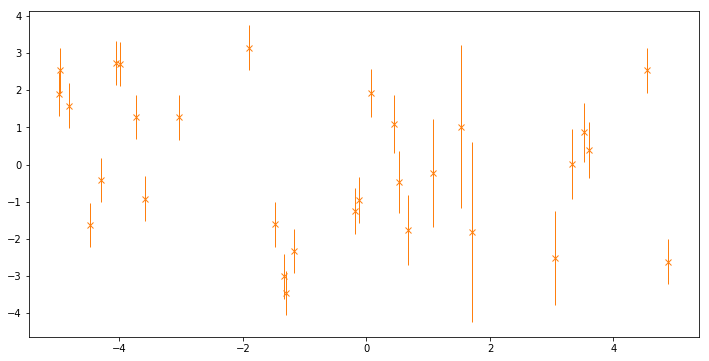

In [88]:
plt.figure(figsize=(12, 6))
plt.errorbar(X, Y, yerr=2*(np.sqrt(Sigma)), marker='x', lw=0, elinewidth=1., color='C1')

### Make a Y matrix that includes the variances
Since GPflow models are based on generalised GP models, we need to coerce out modelling assumptions into that form. All that's needed is to stack the observations with their respective  variances.


In [83]:
Y_data = np.hstack([Y, Sigma])

### Make a new likelihood
To cope with this data type, we'll build a new likelihood. Note how the code extract the observations Y and the variances Sigma from the data.

In [84]:
class HetGaussian(gpflow.likelihoods.Likelihood):
    def logp(self, F, Y_data):
        Y, Sigma = Y_data[:, 0:1], Y_data[:, 1:2]
        return gpflow.logdensities.gaussian(Y, F, Sigma)

    def conditional_mean(self, F):
        raise NotImplementedError

    def conditional_variance(self, F):
        raise NotImplementedError

    def predict_density(self, Fmu, Fvar, Y):
        Y, Sigma = Y_data[:, 0:1], Y_data[:, 1:2]
        return logdensities.gaussian(Y, Fmu, Fvar + Sigma)

    def variational_expectations(self, Fmu, Fvar, Y):
        Y, Sigma = Y_data[:, 0:1], Y_data[:, 1:2]
        return -0.5 * np.log(2 * np.pi) - 0.5 * tf.log(Sigma) \
               - 0.5 * (tf.square(Y - Fmu) + Fvar) / Sigma

### Put it together with VGP
Here we'l build a variational GP model with the above likelihood on the dataset we generated. We'll use the natural gradient optimizer (see also ?link?)

In [85]:
# model construction
likelihood = HetGaussian()
kern = gpflow.kernels.Matern32(1, lengthscales=0.8)
model = gpflow.models.VGP(X, Y_data, kern=kern, likelihood=likelihood)

In [86]:
# build the natural gradients optimizer
natgrad_optimizer = gpflow.training.NatGradOptimizer(gamma=1.)
natgrad_tensor = natgrad_optimizer.make_optimize_tensor(model, var_list=[(model.q_mu, model.q_sqrt)])

# A single natural gradient step:
session = gpflow.get_default_session()
session.run(natgrad_tensor)

# update the cache of the variational parameters in the current session
model.anchor(session)

(-5, 5)

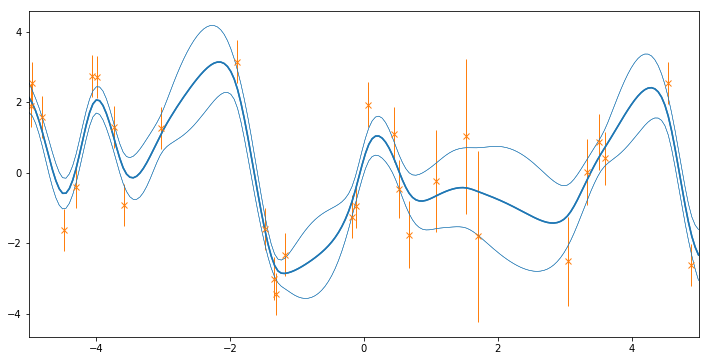

In [87]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

plt.figure(figsize=(12, 6))
plt.plot(xx, mu, 'C0')
plt.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
plt.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

plt.errorbar(X, Y, yerr=2*(np.sqrt(Sigma)), marker='x', lw=0, elinewidth=1., color='C1')
plt.xlim(-5, 5)

### Questions for the reader
1) What is the difference in meaning between the orange vertical bars and the blue regions in the prediction?

2) Why did we not implement conditional_mean and conditional_var in the HetGaussian likelihood?

2) What are some better kernel settings? hint: see the natgrads notebook for help on optmizing kernel parameters alongside variational parameters.